## Competition Dataset Description

### Goal
The aim of this competition is to detect and classify seizures and other types of harmful brain activity using electroencephalography (EEG) data. This task is challenging, with even expert annotators often disagreeing on the correct labels.

### Format
This is a code competition. The test set is not fully available for download, but a few examples are provided. Complete test sets will replace these during scoring.

### Files Description

#### `train.csv`
- **Metadata for the train set:** Includes 50-second long EEG samples and matched spectrograms covering a 10-minute window.
- **Data consolidation:** Many samples overlapped and have been consolidated. `train.csv` provides metadata for extracting the original annotated subsets.
- Fields:
  - `eeg_id`: Unique identifier for the entire EEG recording.
  - `eeg_sub_id`: ID for the specific 50-second long subsample.
  - `eeg_label_offset_seconds`: Time between the beginning of the consolidated EEG and this subsample.
  - `spectrogram_id`: Unique identifier for the entire EEG recording.
  - `spectrogram_sub_id`: ID for the specific 10-minute subsample.
  - `spectogram_label_offset_seconds`: Time between the beginning of the consolidated spectrogram and this subsample.
  - `label_id`: ID for this set of labels.
  - `patient_id`: ID for the patient who donated the data.
  - `expert_consensus`: Consensus annotator label (provided for convenience).
  - `[seizure/lpd/gpd/lrda/grda/other]_vote`: Count of annotator votes for each brain activity class.
    - `lpd`: lateralized periodic discharges
    - `gpd`: generalized periodic discharges
    - `lrd`: lateralized rhythmic delta activity
    - `grda`: generalized rhythmic delta activity
    - Details on these patterns are provided in the dataset.

#### `test.csv`
- **Metadata for the test set:** Does not include overlapping samples, so many columns in the train metadata don't apply.
- Fields:
  - `eeg_id`
  - `spectrogram_id`
  - `patient_id`

#### `sample_submission.csv`
- Fields:
  - `eeg_id`
  - `[seizure/lpd/gpd/lrda/grda/other]_vote`: Target columns for predictions (probabilities).

#### Data Folders
- `train_eegs/`: Contains EEG data from overlapping samples. Use `train.csv` for specific annotated subsets. Includes EEG lead locations and an EKG column for heart data. Data collected at 200 samples per second.
- `test_eegs/`: Contains exactly 50 seconds of EEG data.
- `train_spectrograms/`: Spectrograms assembled from EEG data. Columns indicate frequency in hertz and recording regions of the EEG electrodes (abbreviations included).
- `test_spectrograms/`: Spectrograms assembled using exactly 10 minutes of EEG data.
- `example_figures/`: Larger copies of the example case images used on the overview tab.


In [1]:
# imports

import pandas as pd
import os
import numpy as np
import matplotlib as plt

# a few possible choices for signal processing libraries..
from scipy import signal
# import librosa

import scipy.io
from matplotlib import pyplot as plt
from scipy.signal import hilbert, firls, butter, sosfilt, filtfilt, sosfreqz, stft

from numpy import zeros, ceil, floor, absolute, linspace
from numpy.fft import fft, ifft


import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 50

### Util functions

- /eda_utils.py
    - `plot_eeg_stacks()`
    - `handle_nans()`
    - `apply_referencing()`
    - `get_eeg_spectrogram_pair()`
- /filt_utils.py
    - `plot_filter_freq_response()`
    - `butter_bandpass()`
    - `apply_butter_bandpass()`
    - `apply_firls_bandpass()`
    - `apply_bandpass_filter()`
    - `butter_filter()`
    - `apply_filter()`
- /spectrogram_utils.py
    - `get_spectrogram_from_eeg()`
    - `plot_spectrogram_from_eeg()`
    - `plot_spectrogram_parquet()`
    - `convert_pwr_to_db()`


In [4]:
# local imports -> name the functions lol bad practice. 

from eda_utils import *
from filt_utils import *
from spectrogram_utils import *

https://github.com/AllenDowney/ThinkDSP?tab=readme-ov-file

pretty comprehensive introduction to signal processing with Python...

In [3]:
# change this to local dataset directory
project_dir = '/Users/chaeeunlee/Documents/VSC_workspaces/kaggle_hms_eeg_private/hms-harmful-brain-activity-classification/'

In [5]:
train_csv = pd.read_csv(os.path.join(project_dir, f'train.csv'))
print('train_csv shape:', train_csv.shape )
display(train_csv.head())

example_eeg_ids = train_csv.groupby('expert_consensus')['eeg_id'].agg('first').to_dict()
labels = ['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure']

train_csv shape: (106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [6]:
train_csv['label_id'].nunique()

106800

In [5]:
eeg_df_label = 'LRDA'

In [6]:
# print(train_csv.columns.to_list())

# ###

# print(train_csv['eeg_sub_id'].shape)

# ###

# print(train_csv.shape)

# ###

# grouped = train_csv.groupby('eeg_id').size()

# grouped = grouped.to_dict()
# num_sub_ids_for_each_eeg_id = list(grouped.values())
# print(num_sub_ids_for_each_eeg_id)
# print(sum(num_sub_ids_for_each_eeg_id))

# print(f"max(num_sub_ids_for_each_eeg_id) = {max(num_sub_ids_for_each_eeg_id)}")
# print(f"min(num_sub_ids_for_each_eeg_id) = {min(num_sub_ids_for_each_eeg_id)}")

# ###

# colname = 'label_id'#'patient_id'#'eeg_label_offset_seconds'#'spectrogram_sub_id'#'eeg_id'

# print(train_csv[colname].unique().max())
# print(train_csv[colname].nunique())
# print(train_csv[colname].shape)

# colname = 'eeg_label_offset_seconds'
# # print(train_csv[colname])

# print(train_csv[colname].unique())

In [7]:
train_eegs_path, train_spectrograms_path = os.path.join(project_dir, 'train_eegs/'), os.path.join(project_dir, 'train_spectrograms/')

train_eeg_parquet_list, train_spectrogram_parquet_list = os.listdir(train_eegs_path), os.listdir(train_spectrograms_path)
eeg_parquet_ids, spectrogram_parquet_ids = [int(os.path.splitext(file)[0]) for file in train_eeg_parquet_list], [int(os.path.splitext(file)[0]) for file in train_spectrogram_parquet_list]
eeg_parquet_ids, spectrogram_parquet_ids = set(eeg_parquet_ids), set(spectrogram_parquet_ids)

diff_eeg_spec_parquet_ids = eeg_parquet_ids - spectrogram_parquet_ids # len(diff_spec_eeg_parquet_ids) = 17300
diff_spec_eeg_parquet_ids = spectrogram_parquet_ids - eeg_parquet_ids # len(diff_spec_eeg_parquet_ids) = 11138

print(f"len(train_csv) = {len(train_csv)}")
print(f"len(spectrogram_parquet_ids) = {len(spectrogram_parquet_ids)}")
print(f"len(eeg_parquet_ids) = {len(eeg_parquet_ids)}")
# print(f"diff_spec_eeg_parquet_ids = {diff_spec_eeg_parquet_ids}")
print(f"len(diff_spec_eeg_parquet_ids) = {len(diff_spec_eeg_parquet_ids)}")
# print(f"diff_eeg_spec_parquet_ids = {diff_eeg_spec_parquet_ids}")
print(f"len(diff_eeg_spec_parquet_ids) = {len(diff_eeg_spec_parquet_ids)}")

print()
print(f"eeg and spec parquet file names don't match at all. we have to refer to train.csv to match eegs to specs")
print()

# print(train_csv['eeg_id'].unique())

eeg_parquet_ids = set(eeg_parquet_ids)
train_csv_eeg_ids = set(train_csv['eeg_id'].unique())

diff = eeg_parquet_ids - train_csv_eeg_ids

print(diff)
print(len(diff))

# assert eeg_parquet_ids==train_csv['eeg_id'].unique(), "eeg ids in tran.csv do not match parquet files"

len(train_csv) = 106800
len(spectrogram_parquet_ids) = 11138
len(eeg_parquet_ids) = 17300
len(diff_spec_eeg_parquet_ids) = 11138
len(diff_eeg_spec_parquet_ids) = 17300

eeg and spec parquet file names don't match at all. we have to refer to train.csv to match eegs to specs

{3576774144, 2734605314, 3425324038, 2989528583, 3624732686, 2021270543, 1980230677, 1006575126, 2585735707, 463419419, 2437996061, 1218899486, 2883273759, 1046303268, 710494757, 3374558757, 124842023, 507760170, 876702254, 1362609712, 2564933177, 2069539903, 2512462400, 1484488768, 2370617920, 1124971078, 397155403, 735478859, 2495888973, 176751182, 4265462352, 2256830545, 512986705, 495719000, 3973402202, 535701085, 1540422245, 2514244198, 2163060838, 2704546408, 3726556263, 2518637163, 3713571437, 4118489199, 1593654895, 3965080689, 3184041077, 358214261, 888227967, 2032669824, 3861560461, 3534133394, 4066543763, 3613550741, 990852758, 2945876125, 771666080, 3029056160, 2360465057, 789759143, 595031723, 389713783

In [8]:
eeg_file_id = example_eeg_ids[eeg_df_label]
print(f"eeg_file_id = {eeg_file_id}") # eeg_file_id = 722738444 ('LRDA')

matching_spectrogram_file_id = train_csv.loc[train_csv['eeg_id'] == eeg_file_id, 'spectrogram_id'].values[0] # if not train_csv[train_csv['eeg_id'] == eeg_file_id].empty else None
print(f"matching_spectrogram_file_id = {matching_spectrogram_file_id}")
print()
print(train_csv.loc[train_csv['eeg_id'] == eeg_file_id].iloc[0])



train_eeg_sample = os.path.join(project_dir, f'train_eegs/{eeg_file_id}.parquet')
train_spectrogram_sample = os.path.join(project_dir, f'train_spectrograms/{matching_spectrogram_file_id}.parquet')

eeg_df = pd.read_parquet(train_eeg_sample, engine='pyarrow')
spectrogram_df = pd.read_parquet(train_spectrogram_sample, engine='pyarrow')

display(eeg_df.head())
display(spectrogram_df.head())

eeg_file_id = 722738444
matching_spectrogram_file_id = 999431

eeg_id                              722738444
eeg_sub_id                                  0
eeg_label_offset_seconds                  0.0
spectrogram_id                         999431
spectrogram_sub_id                          0
spectrogram_label_offset_seconds          0.0
label_id                            557980729
patient_id                              56885
expert_consensus                         LRDA
seizure_vote                                0
lpd_vote                                    1
gpd_vote                                    0
lrda_vote                                  14
grda_vote                                   0
other_vote                                  1
Name: 11, dtype: object


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-33.500000,-15.950000,27.120001,19.670000,10.10,18.610001,27.379999,-2.13,-16.750000,1.86,-3.19,-52.900002,-44.400002,25.790001,13.560000,-20.740000,-77.089996,-58.220001,-22.059999,-2.39
1,-30.570000,-12.760000,28.180000,21.530001,13.03,15.150000,27.379999,0.00,-15.680000,2.92,0.53,-52.369999,-44.930000,30.570000,22.330000,-21.799999,-70.180000,-48.650002,-18.340000,2.93
2,-34.029999,-18.610001,24.990000,15.420000,4.79,13.560000,22.059999,-5.05,-18.340000,0.53,-4.79,-55.830002,-48.910000,29.240000,25.790001,-19.940001,-62.740002,-46.790001,-22.330000,2.39
3,-32.430000,-18.610001,26.850000,19.139999,5.05,13.290000,24.190001,0.00,-19.940001,3.72,0.00,-55.029999,-47.590000,31.900000,34.029999,-11.170000,-53.700001,-39.610001,-16.219999,-3.46
4,-30.309999,-11.700000,34.029999,27.650000,13.56,21.270000,34.560001,10.37,-19.410000,8.24,8.77,-55.560001,-47.590000,32.959999,42.529999,-8.240000,-47.849998,-27.910000,-4.250000,0.00


,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,1,11.34,12.94,14.67,12.46,8.01,6.02,4.04,2.92,3.28,...,0.04,0.04,0.05,0.03,0.05,0.07,0.08,0.07,0.08,0.06
1,3,4.57,5.72,6.07,4.09,2.98,1.51,1.08,1.12,0.94,...,0.09,0.09,0.06,0.07,0.05,0.07,0.07,0.05,0.05,0.04
2,5,7.53,10.54,9.15,8.42,5.05,2.45,1.14,0.92,0.87,...,0.11,0.13,0.11,0.13,0.12,0.10,0.10,0.10,0.06,0.05
3,7,11.00,14.37,15.18,13.68,9.69,5.41,2.28,2.51,2.15,...,0.09,0.16,0.13,0.11,0.11,0.11,0.09,0.10,0.08,0.08
4,9,5.30,5.44,5.92,5.10,4.47,3.64,3.28,4.08,2.17,...,0.08,0.10,0.11,0.08,0.09,0.09,0.09,0.11,0.12,0.06


<!-- <img src="Bipolar_Double_Banana_Montage.png"> -->

### BDB Montage Layout

https://www.learningeeg.com/montages-and-technical-components for more

odd numbers for left and even numbers for right hemisphere

<div>
<img src="Bipolar_Double_Banana_Montage.png" width="500"/>
</div>

<!-- <div>
<img src="bdb_montage_layout.png" width="800"/>
</div> -->

In [9]:
cols = eeg_df.columns.to_list()
print(cols)

eeg_df[cols[3]].shape # = (14800,) 

print(14800/200) # 74.0 sec

['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
74.0


In [10]:
eeg_df = handle_nans(eeg_df) # doesn't seem to have NaN values but didn't check every file. 

NaN ratio for column 'Fp1': 0.0
NaN ratio for column 'F3': 0.0
NaN ratio for column 'C3': 0.0
NaN ratio for column 'P3': 0.0
NaN ratio for column 'F7': 0.0
NaN ratio for column 'T3': 0.0
NaN ratio for column 'T5': 0.0
NaN ratio for column 'O1': 0.0
NaN ratio for column 'Fz': 0.0
NaN ratio for column 'Cz': 0.0
NaN ratio for column 'Pz': 0.0
NaN ratio for column 'Fp2': 0.0
NaN ratio for column 'F4': 0.0
NaN ratio for column 'C4': 0.0
NaN ratio for column 'P4': 0.0
NaN ratio for column 'F8': 0.0
NaN ratio for column 'T4': 0.0
NaN ratio for column 'T6': 0.0
NaN ratio for column 'O2': 0.0
NaN ratio for column 'EKG': 0.0


In [11]:
referenced_eeg_df = apply_referencing(eeg_df, mode='bdb_montage')

print(referenced_eeg_df.shape)

(14800, 16)


### Referencing from the linked youtube vids (note labels on the left side. im assuming these are simple subtractions)

There are some differences with given dataset. (e.g. we don't have electrode T7)

<div>
<img src="bdb_montage_layout.png" width="800"/>
</div>

Columns: ['P4 - O2', 'C4 - P4', 'F4 - C4', 'Fp2 - F4', 'T6 - O2', 'T4 - T6', 'F8 - T4', 'Fp2 - F8', 'P3 - O1', 'C3 - P3', 'F3 - C3', 'Fp1 - F3', 'T5 - O1', 'T3 - T5', 'F7 - T3', 'Fp1 - F7']


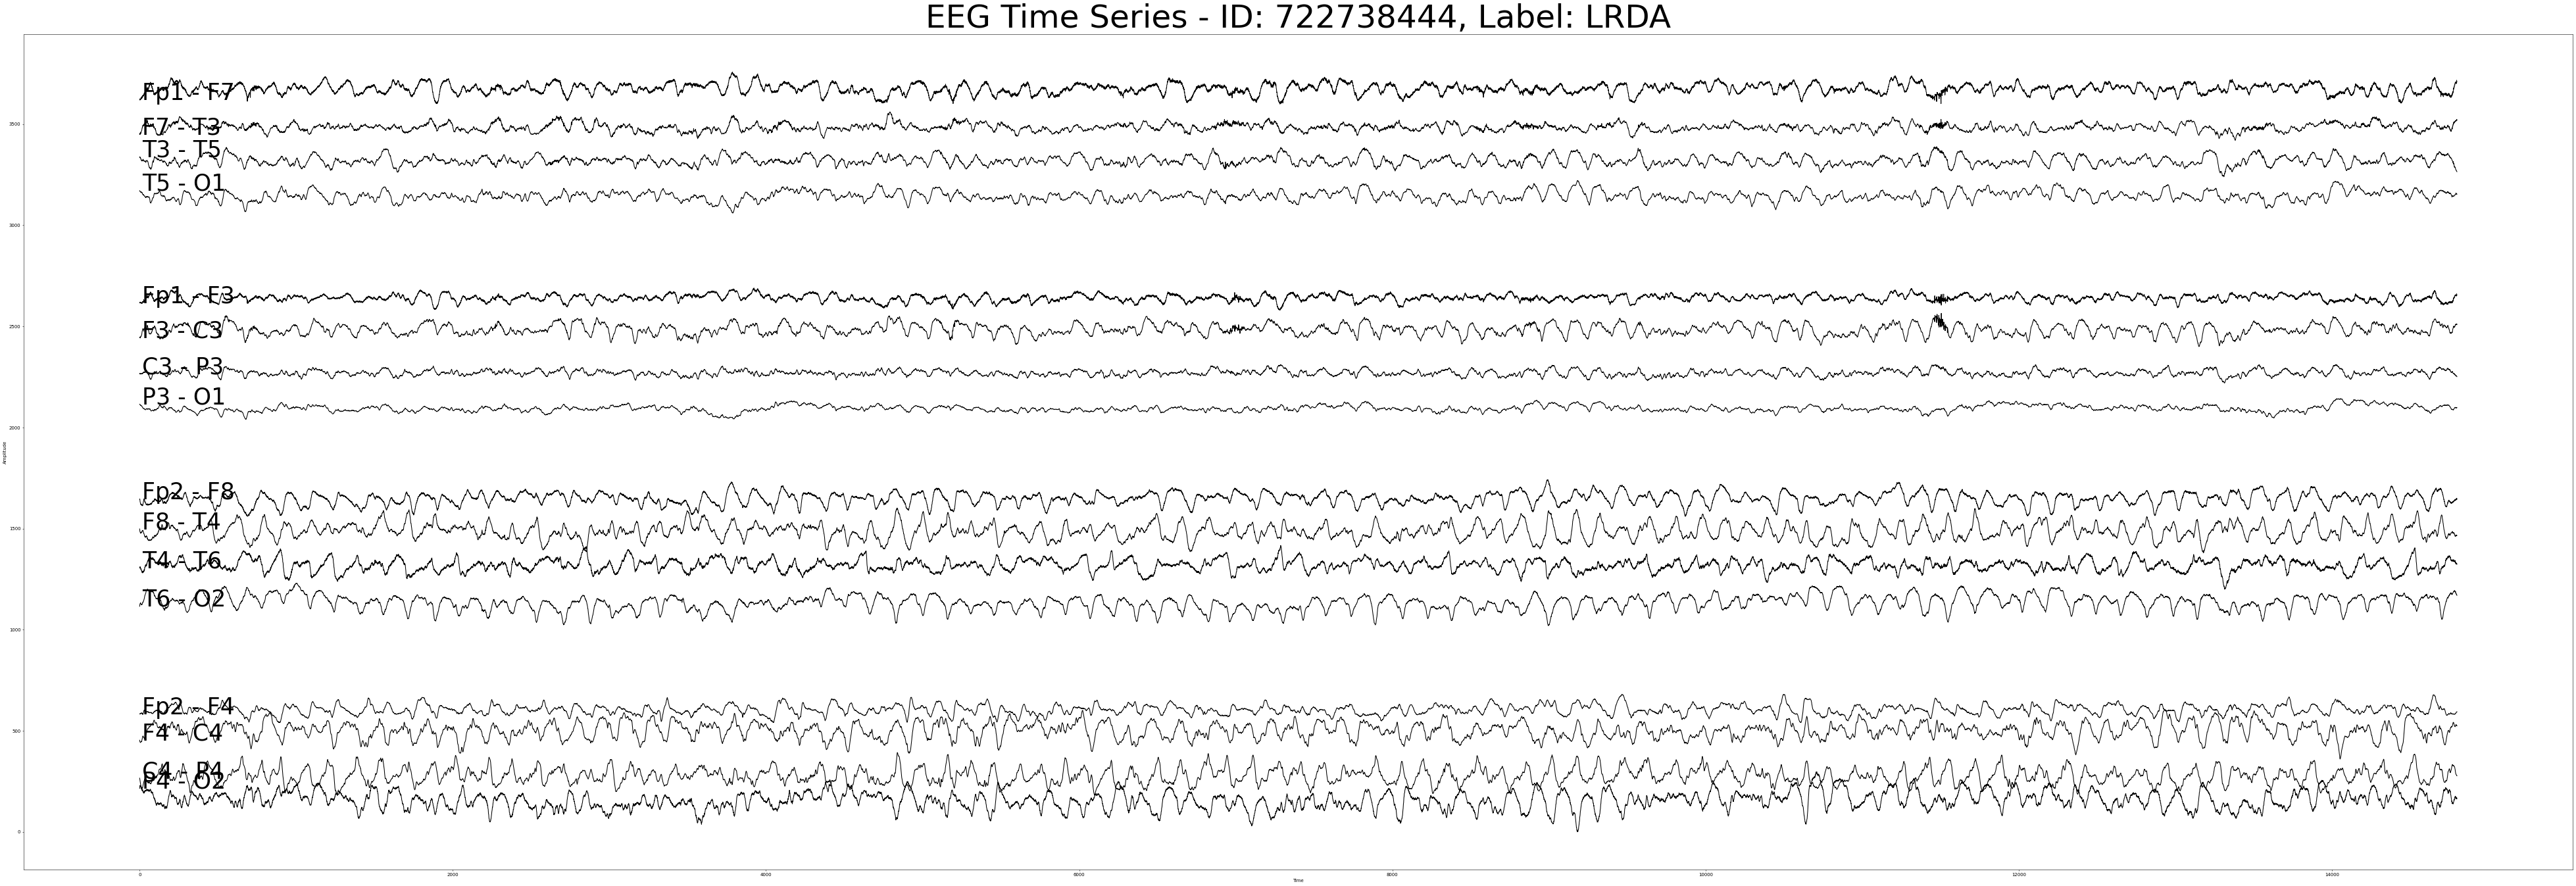

In [12]:
plot_eeg_stacks(referenced_eeg_df, eeg_file_id, eeg_df_label, mode='bdb_montage') #
# plot_eeg_stacks(eeg_df)

Columns: ['P4 - O2', 'C4 - P4', 'F4 - C4', 'Fp2 - F4', 'T6 - O2', 'T4 - T6', 'F8 - T4', 'Fp2 - F8', 'P3 - O1', 'C3 - P3', 'F3 - C3', 'Fp1 - F3', 'T5 - O1', 'T3 - T5', 'F7 - T3', 'Fp1 - F7']


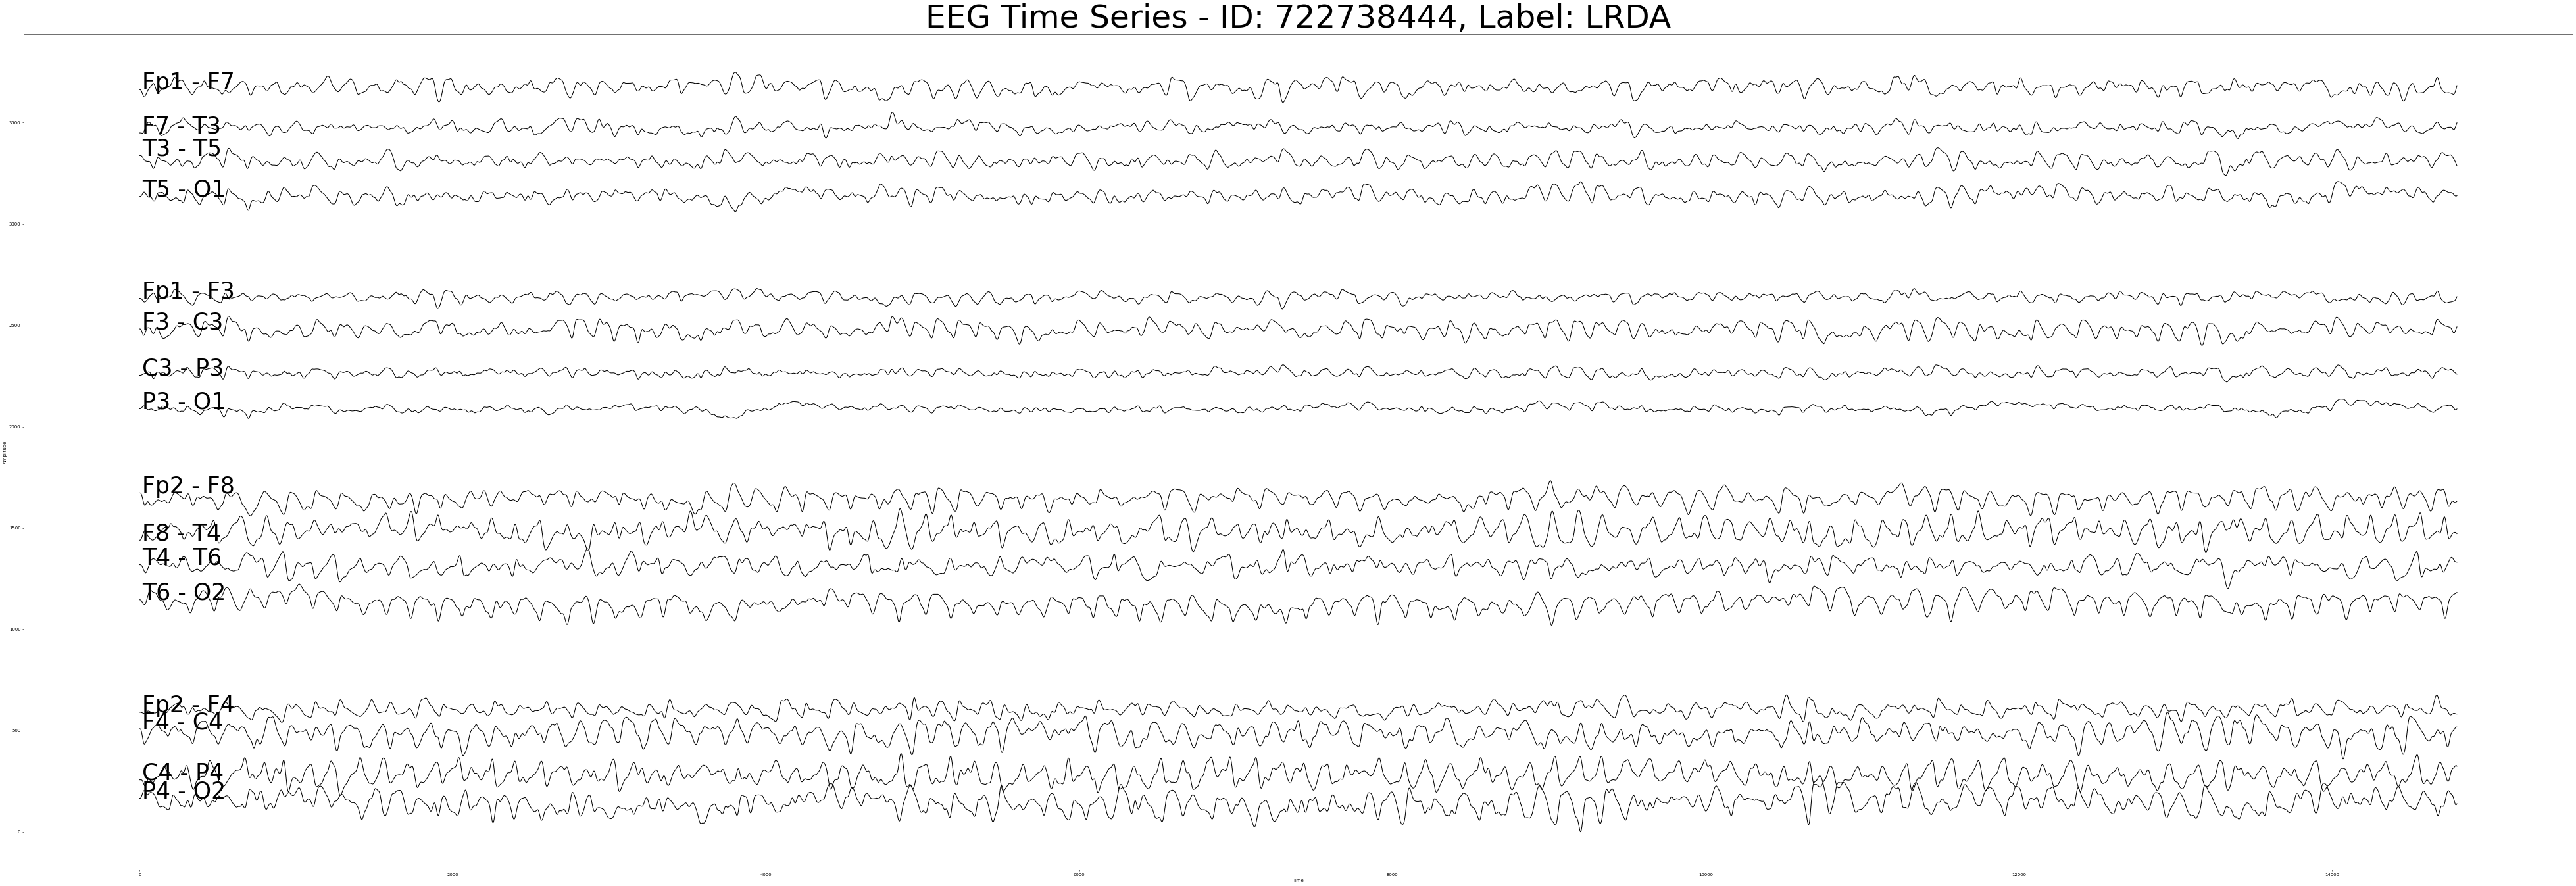

In [13]:
## EEG signals referenced and low-pass filtered

low_filtered_eeg_df = apply_filter(eeg_df, cutoff_freq=5, srate=200, filter_type='low')
referenced_n_filtered_eeg_df = apply_referencing(low_filtered_eeg_df, mode='bdb_montage') # global_avg

plot_eeg_stacks(referenced_n_filtered_eeg_df, eeg_file_id, eeg_df_label, mode='bdb_montage') #

In [14]:
prefixes = set(column[:2] for column in spectrogram_df.columns)
print(prefixes)

chains4spec = prefixes - {'ti'}
chains4spec = list(chains4spec)

for prefix in prefixes - {'ti'}:
    count = sum(column.startswith(prefix) for column in spectrogram_df.columns)
    # print(f"Number of columns starting with '{prefix}': {count}")
    print(f"{count} frequency values for region {prefix}")

{'RP', 'RL', 'LL', 'LP', 'ti'}
100 frequency values for region RL
100 frequency values for region RP
100 frequency values for region LP
100 frequency values for region LL


In [15]:

partitioned_dfs = {}

for chain in chains4spec:
    # Filter columns that start with the current chain
    filtered_columns = [col for col in spectrogram_df.columns if col.startswith(chain)]
    
    # Create a new DataFrame with these columns
    partitioned_dfs[chain] = spectrogram_df[filtered_columns] # dictionary of dfs

# Now, partitioned_dfs['RL'], partitioned_dfs['ti'], etc., are your separate DataFrames
    
for chain_name, sub_df in partitioned_dfs.items():
    # print(sub_df)
    # print(chain_name)
    display(sub_df.head(3))


,RL_0.59,RL_0.78,RL_0.98,RL_1.17,RL_1.37,RL_1.56,RL_1.76,RL_1.95,RL_2.15,RL_2.34,...,RL_18.16,RL_18.36,RL_18.55,RL_18.75,RL_18.95,RL_19.14,RL_19.34,RL_19.53,RL_19.73,RL_19.92
0,74.809998,89.250000,106.209999,81.680000,52.349998,42.119999,27.549999,9.59,9.33,7.72,...,0.06,0.08,0.04,0.05,0.06,0.06,0.06,0.07,0.07,0.06
1,36.349998,44.959999,35.560001,30.719999,29.990000,16.410000,10.500000,12.40,8.75,6.62,...,0.08,0.06,0.09,0.11,0.07,0.08,0.05,0.03,0.04,0.04
2,54.020000,46.290001,44.759998,35.630001,18.590000,14.900000,11.370000,8.39,8.64,6.97,...,0.06,0.07,0.08,0.09,0.08,0.08,0.03,0.07,0.06,0.07


,RP_0.59,RP_0.78,RP_0.98,RP_1.17,RP_1.37,RP_1.56,RP_1.76,RP_1.95,RP_2.15,RP_2.34,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
0,95.400002,98.879997,90.370003,67.779999,34.23,33.220001,39.150002,20.030001,18.15,20.51,...,0.04,0.04,0.05,0.03,0.05,0.07,0.08,0.07,0.08,0.06
1,38.740002,44.880001,55.439999,45.779999,34.00,31.600000,20.469999,17.400000,14.11,9.89,...,0.09,0.09,0.06,0.07,0.05,0.07,0.07,0.05,0.05,0.04
2,44.130001,47.860001,48.759998,33.590000,26.74,16.420000,14.200000,13.560000,11.80,12.73,...,0.11,0.13,0.11,0.13,0.12,0.10,0.10,0.10,0.06,0.05


,LP_0.59,LP_0.78,LP_0.98,LP_1.17,LP_1.37,LP_1.56,LP_1.76,LP_1.95,LP_2.15,LP_2.34,...,LP_18.16,LP_18.36,LP_18.55,LP_18.75,LP_18.95,LP_19.14,LP_19.34,LP_19.53,LP_19.73,LP_19.92
0,11.12,14.26,15.19,13.96,10.47,5.64,3.87,2.90,2.09,1.58,...,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.03,0.02
1,3.33,5.00,5.70,4.89,3.63,1.85,1.00,0.72,0.50,0.44,...,0.02,0.03,0.03,0.02,0.02,0.01,0.01,0.01,0.02,0.02
2,6.67,12.47,11.51,9.97,7.25,3.70,1.14,1.40,1.21,1.05,...,0.02,0.02,0.03,0.03,0.04,0.03,0.03,0.03,0.02,0.02


,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,LL_2.34,...,LL_18.16,LL_18.36,LL_18.55,LL_18.75,LL_18.95,LL_19.14,LL_19.34,LL_19.53,LL_19.73,LL_19.92
0,11.34,12.94,14.67,12.46,8.01,6.02,4.04,2.92,3.28,1.99,...,0.04,0.04,0.03,0.03,0.04,0.03,0.03,0.02,0.03,0.02
1,4.57,5.72,6.07,4.09,2.98,1.51,1.08,1.12,0.94,0.78,...,0.02,0.03,0.03,0.04,0.03,0.03,0.03,0.02,0.02,0.02
2,7.53,10.54,9.15,8.42,5.05,2.45,1.14,0.92,0.87,0.96,...,0.02,0.03,0.03,0.03,0.04,0.03,0.03,0.04,0.04,0.04


In [16]:
type(partitioned_dfs['LL'])

pandas.core.frame.DataFrame

spec_vals.shape = (100, 312)
ref_power = 18.730432510375977
spec_vals.shape = (100, 312)
ref_power = 23.5307559967041
spec_vals.shape = (100, 312)
ref_power = 6.063564777374268
spec_vals.shape = (100, 312)
ref_power = 8.484469413757324


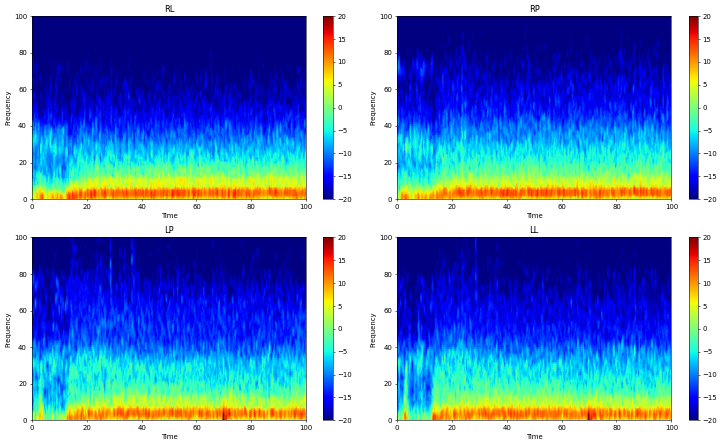

spec_vals.shape = (100, 312)
spec_vals.shape = (100, 312)
spec_vals.shape = (100, 312)
spec_vals.shape = (100, 312)


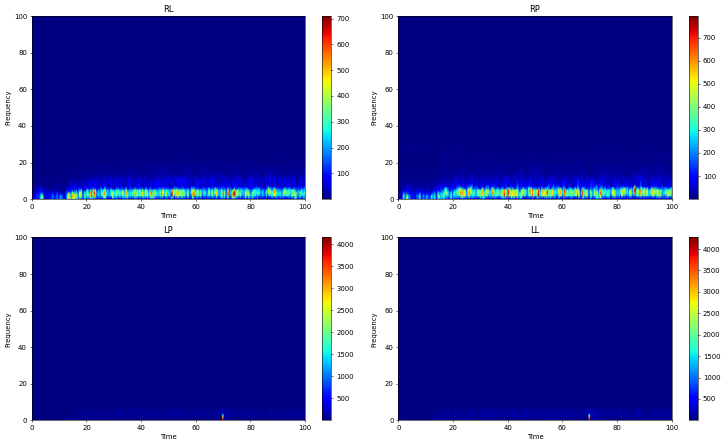

In [17]:

plot_spectrogram_parquet(partitioned_dfs, convert_to_db=True, fix_colorbar_range=True)
plot_spectrogram_parquet(partitioned_dfs, convert_to_db=False, fix_colorbar_range=False)


Looks like spectrogram parquets are raw STFT values before scaling (e.g. db conversion) ?? someone could look into this

In [18]:
partitioned_dfs['LL'].shape # (312, 100) -> has to be transposed

(312, 100)

### Spectrogram Debugging To-dos

1. single-channel to chain (with diff formulae) 
    - STFT applied to averaged EEG for each chain? 
    - STFT to single-chan EEG then avg?
    - Deotte's "magic formula": `LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4`
        - https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760
2. ref_power
    - max or avg?
    - for single-chan or chain-avg?
3. segment length and noverlap
    - this is non-trivial
4. try diff power scaling than decibel conversion
    - probs less important
    - which transformation was used for specs in the dataset?
5. Try different interpolation methods
6. Miscellaneous
    - `contourf` vs. `pcolormesh` (only relevant for visualization)
    - which colormap? sample images seem to be using jet?

find comb closest to spectrograms given in the dataset


<!-- #### `train.csv`
- **Metadata for the train set:** Includes 50-second long EEG samples and matched spectrograms covering a 10-minute window.
- **Data consolidation:** Many samples overlapped and have been consolidated. `train.csv` provides metadata for extracting the original annotated subsets.
- Fields:
  - `eeg_id`: Unique identifier for the entire EEG recording.
  - `eeg_sub_id`: ID for the specific 50-second long subsample.
  - `eeg_label_offset_seconds`: Time between the beginning of the consolidated EEG and this subsample.
  - `spectrogram_id`: Unique identifier for the entire EEG recording.
  - `spectrogram_sub_id`: ID for the specific 10-minute subsample.
  - `spectogram_label_offset_seconds`: Time between the beginning of the consolidated spectrogram and this subsample.
  - `label_id`: ID for this set of labels.
  - `patient_id`: ID for the patient who donated the data.
  - `expert_consensus`: Consensus annotator label (provided for convenience).
  - `[seizure/lpd/gpd/lrda/grda/other]_vote`: Count of annotator votes for each brain activity class.
    - `lpd`: lateralized periodic discharges
    - `gpd`: generalized periodic discharges
    - `lrd`: lateralized rhythmic delta activity
    - `grda`: generalized rhythmic delta activity
    - Details on these patterns are provided in the dataset. -->

In [19]:
electrode_name = 'T3'
eeg = eeg_df[electrode_name]  # Single-channel!
print(f"eeg.shape = {eeg.shape}")
f, t, Sxx = get_spectrogram_from_eeg(eeg)

eeg.shape = (14800,)


In [20]:
# type(Sxx) # numpy.ndarray

# ah dang maybe the dimension has to be the same with Kaggle spectrograms?
Sxx.shape # (129, 65)
# wait does this affect filtering? -> nah. 

print(f"{14800/200}") # 74. why is this 74 secs and not 50 secs. ah okay yeah that's not a problem. 

# but then how do we get to the number 129? it probs has to to with nperseg and noverlap. 

74.0


ref_power = 20.12843894958496


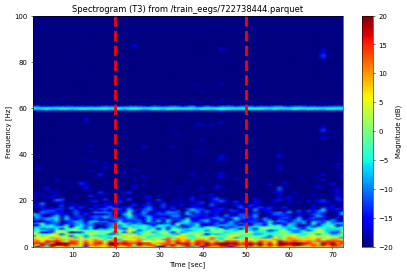

In [21]:
plot_spectrogram_from_eeg(f, t, Sxx, electrode_name, eeg_file_id, time_regions=[20, 50])

Cohen: "notch filters at 50 Hz or 60 Hz help attenuate electrical line noise."

In [22]:
# spectrogram parquets -> spec_vals.shape = (100, 312) -> 100 freq responses and 312 time points

# Sxx.shape # (129, 65) -> shorter time points makes sense since eeg signals are only for 50 secs
# f.shape # 129
# t.shape # (65,)

t.max() # 72.32 sec
f.max() # 100.0 -> this is probs Nyquist. 

100.0